[Hands-On Computer Vision with TensorFlow 2 -- Chapter 6: AutoEncoders](https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/tree/master/Chapter06)

**Resources**:

- [Autoencoder | Wikipedia](https://en.wikipedia.org/wiki/Autoencoder)

- [Implementing an Autoencoder in TensorFlow 2.0 | Towards Data Science](https://towardsdatascience.com/implementing-an-autoencoder-in-tensorflow-2-0-5e86126e9f7)

- [Introduction to Autoencoders | Jeremy Jordan](https://www.jeremyjordan.me/autoencoders/)

In [ ]:
import tensorflow as tf
import os
import math
import numpy as np

# Some hyper-parameters:
batch_size  = 128           # Images per batch (reduce/increase according to the machine's capability)
num_epochs  = 60            # Max number of training epochs
random_seed = 42            # Seed for some random operations, for reproducibility

In [ ]:
import tensorflow_datasets as tfds

mnist_builder = tfds.builder("mnist")
mnist_builder.download_and_prepare()

mnist_info = mnist_builder.info
print(mnist_info)

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.0,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



In [ ]:
import functools

def _prepare_data_fn(features, target='label', flatten=True,
                     return_batch_as_tuple=True, seed=None):
    """
    Resize image to expected dimensions, and opt. apply some random transformations.
    :param features:              Data
    :param target                 Target/ground-truth data to be returned along the images
                                  ('label' for categorical labels, 'image' for images, or None)
    :param flatten:               Flag to flatten the images, from (28, 28, 1) to (784,)
    :param return_batch_as_tuple: Flag to return the batch data as tuple instead of dict
    :param seed:                  Seed for random operations
    :return:                      Processed data
    """
    
    # Tensorflow-Dataset returns batches as feature dictionaries, expected by Estimators.
    # To train Keras models, it is more straightforward to return the batch content as tuples.
    
    image = features['image']
    # Convert the images to float type, also scaling their values from [0, 255] to [0., 1.]:
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    if flatten:
        is_batched = len(image.shape) > 3
        flattened_shape = (-1, 784) if is_batched else (784,)
        image = tf.reshape(image, flattened_shape)
        
    if target is None:
        return image if return_batch_as_tuple else {'image': image}
    else:
        features['image'] = image
        return (image, features[target]) if return_batch_as_tuple else features

def get_mnist_dataset(phase='train', target='label', batch_size=32, num_epochs=None, 
                      shuffle=True, flatten=True, return_batch_as_tuple=True, seed=None):
    """
    Instantiate a CIFAR-100 dataset.
    :param phase:                 Phase ('train' or 'val')
    :param target                 Target/ground-truth data to be returned along the images
                                  ('label' for categorical labels, 'image' for images, or None)
    :param batch_size:            Batch size
    :param num_epochs:            Number of epochs (to repeat the iteration - infinite if None)
    :param shuffle:               Flag to shuffle the dataset (if True)
    :param flatten:               Flag to flatten the images, from (28, 28, 1) to (784,)
    :param return_batch_as_tuple: Flag to return the batch data as tuple instead of dict
    :param seed:                  Seed for random operations
    :return:                      Iterable Dataset
    """

    assert(phase == 'train' or phase == 'test')
    
    prepare_data_fn = functools.partial(_prepare_data_fn, return_batch_as_tuple=return_batch_as_tuple,
                                        target=target, flatten=flatten, seed=seed)

    mnist_dataset = mnist_builder.as_dataset(split=tfds.Split.TRAIN if phase =='train' else tfds.Split.TEST)
    mnist_dataset = mnist_dataset.repeat(num_epochs)
    if shuffle:
        mnist_dataset = mnist_dataset.shuffle(10000, seed=seed)
    mnist_dataset = mnist_dataset.batch(batch_size)
    mnist_dataset = mnist_dataset.map(prepare_data_fn, num_parallel_calls=4)
    mnist_dataset = mnist_dataset.prefetch(1)
    
    return mnist_dataset

In [ ]:
# Number of classes:
num_classes = mnist_info.features['label'].num_classes

# Number of images:
num_train_imgs = mnist_info.splits['train'].num_examples
num_val_imgs = mnist_info.splits['test'].num_examples

train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch   = math.ceil(num_val_imgs / batch_size)

train_mnist_dataset = get_mnist_dataset(
    phase='train', target='image', batch_size=batch_size, num_epochs=num_epochs, 
    shuffle=True, flatten=True, seed=random_seed)

val_mnist_dataset = get_mnist_dataset(
    phase='test', target='image', batch_size=batch_size, num_epochs=1, 
    shuffle=False, flatten=True, seed=random_seed)

input_shape = mnist_info.features['image'].shape
flattened_input_shape = [np.prod(input_shape)]

In [ ]:
code_size = 32

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

inputs = Input(flattened_input_shape, name='input')

# Encoding layers
enc_1 = Dense(128, activation='relu', name='enc_dense_1')(inputs)
enc_2 = Dense(64, activation='relu', name='enc_dense_2')(enc_1)
code = Dense(code_size, activation='relu', name='enc_dense_3')(enc_2)

# Decoding layers
dec_1 = Dense(64, activation='relu', name='dec_dense_1')(code)
dec_2 = Dense(128, activation='relu', name='dec_dense_2')(dec_1)
decoded = Dense(flattened_input_shape[0], activation='sigmoid', name='dec_dense_3')(dec_2)

# Autoencoder model
autoencoder = Model(inputs, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
enc_dense_1 (Dense)          (None, 128)               100480    
_________________________________________________________________
enc_dense_2 (Dense)          (None, 64)                8256      
_________________________________________________________________
enc_dense_3 (Dense)          (None, 32)                2080      
_________________________________________________________________
dec_dense_1 (Dense)          (None, 64)                2112      
_________________________________________________________________
dec_dense_2 (Dense)          (None, 128)               8320      
_________________________________________________________________
dec_dense_3 (Dense)          (None, 784)               101136

In [ ]:
encoder = Model(inputs, code)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
enc_dense_1 (Dense)          (None, 128)               100480    
_________________________________________________________________
enc_dense_2 (Dense)          (None, 64)                8256      
_________________________________________________________________
enc_dense_3 (Dense)          (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


In [ ]:
input_code = Input(shape=(code_size,), name='input_code')

num_decoder_layers = 3
dec_i = input_code

for i in range(num_decoder_layers, 0, -1):
    dec_layer = autoencoder.layers[-i]
    dec_i = dec_layer(dec_i)

decoder = Model(input_code, dec_i)
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_code (InputLayer)      [(None, 32)]              0         
_________________________________________________________________
dec_dense_1 (Dense)          (None, 64)                2112      
_________________________________________________________________
dec_dense_2 (Dense)          (None, 128)               8320      
_________________________________________________________________
dec_dense_3 (Dense)          (None, 784)               101136    
Total params: 111,568
Trainable params: 111,568
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def log_n(x, n=10):
    """
    Compute log_n(x), i.e. the log base `n` value of `x`.
    :param x:   Input tensor
    :param n:   Value of the log base
    :return:    Log result
    """
    log_e = tf.math.log(x)
    div_log_n = tf.math.log(tf.constant(n, dtype=log_e.dtype))
    return log_e / div_log_n


def psnr(img_a, img_b, max_img_value=255):
    """
    Compute the PSNR (Peak Signal-to-Noise Ratio) between two images.
    :param img_a:           Image A
    :param img_b:           Image B
    :param max_img_value:   Maximum possible pixel value of the images
    :return:                PSNR value
    """
    mse = tf.reduce_mean((img_a - img_b) ** 2)
    return 20 * log_n(max_img_value, 10) - 10 * log_n(mse, 10)

In [ ]:
import functools

psnr_metrics = functools.partial(psnr, max_img_value=1.)
psnr_metrics.__name__ = 'psnr'

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import math

class DynamicPlotCallback(tf.keras.callbacks.Callback):
        
    def on_train_begin(self, logs={}):
        # This method will be called when the training start.
        # Therefore, we use it to initialize some elements for our Callback:
        self.logs = dict()
        self.fig, self.ax = None, None
 
    def on_epoch_end(self, epoch, logs={}):
        # This method will be called after each epoch.
        # Keras will call this function, providing the current epoch number,
        # and the values of the various losses/metrics for this epoch (`logs` dict).
        
        # We add the new log values to the list...
        for key, val in logs.items():
            if key not in self.logs:
                self.logs[key] = []
            self.logs[key].append(val)
        # ... then we plot everything:
        self._plot_logs()
 
    def on_train_end(self, logs={}):
        pass    # our callback does nothing special at the end of the training
 
    def on_epoch_begin(self, epoch, logs={}):
        pass   # ... nor at the beginning of a new epoch
 
    def on_batch_begin(self, batch, logs={}):
        pass   # ... nor at the beginning of a new batch
 
    def on_batch_end(self, batch, logs={}):
        pass   # ... nor after.
    
    def _plot_logs(self):
        # Method to clear the figures and draw them over with new values:
        if self.fig is None: # First call - we initialize the figure:
            num_metrics = len(self.logs) 
            self.fig, self.ax = plt.subplots(math.ceil(num_metrics / 2), 2, figsize=(10, 8))
            self.fig.show()
            self.fig.canvas.draw()
        
        # Plotting:
        i = 0
        for key, val in self.logs.items():
            id_vert, id_hori = i // 2, i % 2
            self.ax[id_vert, id_hori].clear()
            self.ax[id_vert, id_hori].set_title(key)
            self.ax[id_vert, id_hori].plot(val)
            i += 1
        
        #self.fig.tight_layout()
        self.fig.subplots_adjust(right=0.75, bottom=0.25)
        self.fig.canvas.draw()

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy',
                    metrics=[psnr_metrics])

history = autoencoder.fit(
    train_mnist_dataset, epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=val_mnist_dataset, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=[DynamicPlotCallback()])

<IPython.core.display.Javascript object>

In [ ]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import numpy as np

def show_pairs(samples_a, samples_b, 
               plot_fn_a="imshow", plot_fn_b="imshow"):
    """
    Plot pairs of data
    :param samples_a:   List of samples A
    :param samples_b:   List of samples B
    :param plot_fn_a:   Name of Matplotlib function to plot A (default: "imshow")
    :param plot_fn_b:   Name of Matplotlib function to plot B (default: "imshow")
    :return:            /
    """
    assert(len(samples_a) == len(samples_b))
    num_images = len(samples_a)
    
    figure = plt.figure(figsize=(num_images, 2))
    grid_spec = gridspec.GridSpec(1, num_images)
    for i in range(num_images):
        
        grid_spec_i = gridspec.GridSpecFromSubplotSpec(
            2, 1, subplot_spec=grid_spec[i], hspace=0)
        
        # Drawing image A:
        ax_img = figure.add_subplot(grid_spec_i[0])
        getattr(ax_img, plot_fn_a)(samples_a[i])
        plt.gray()
        ax_img.get_xaxis().set_visible(False)
        ax_img.get_yaxis().set_visible(False)
        
        # Drawing image B:
        ax_img = figure.add_subplot(grid_spec_i[1])
        getattr(ax_img, plot_fn_b)(samples_b[i])
        plt.gray()
        ax_img.get_xaxis().set_visible(False)
        ax_img.get_yaxis().set_visible(False)
        
    # plt.tight_layout()
    plt.show()

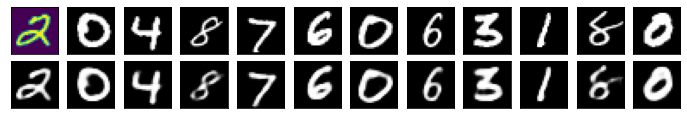

In [ ]:
num_show = 12

x_test_sample = next(val_mnist_dataset.__iter__())[0][:num_show].numpy()
x_decoded = autoencoder.predict_on_batch(x_test_sample)
show_pairs(x_test_sample.reshape(num_show, *input_shape[:2]), 
           x_decoded.reshape(num_show, *input_shape[:2]))

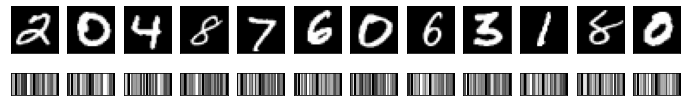

In [ ]:
x_encoded = encoder.predict_on_batch(x_test_sample)

# We scale up the code, to better visualize it:
x_encoded_show = np.tile(x_encoded.reshape(num_show, 1, code_size), (1, 15, 1))

show_pairs(x_test_sample.reshape(num_show, *input_shape[:2]), 
           x_encoded_show, plot_fn_b="matshow")

In [ ]:
from sklearn.manifold import TSNE
# Creating a t-SNE instance to project our codes into 2D elements:
tsne = TSNE(n_components=2, verbose=1, random_state=0)

In [ ]:
_, (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_test = x_test / 255.0
x_test = x_test.reshape(x_test.shape[0], *flattened_input_shape)

x_encoded = encoder.predict_on_batch(x_test)
x_2d = tsne.fit_transform(x_encoded)

11493376/11490434 [==============================] - 0s 0us/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.036s...
[t-SNE] Computed neighbors for 10000 samples in 7.570s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 3.872086
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.468018
[t-SNE] KL div

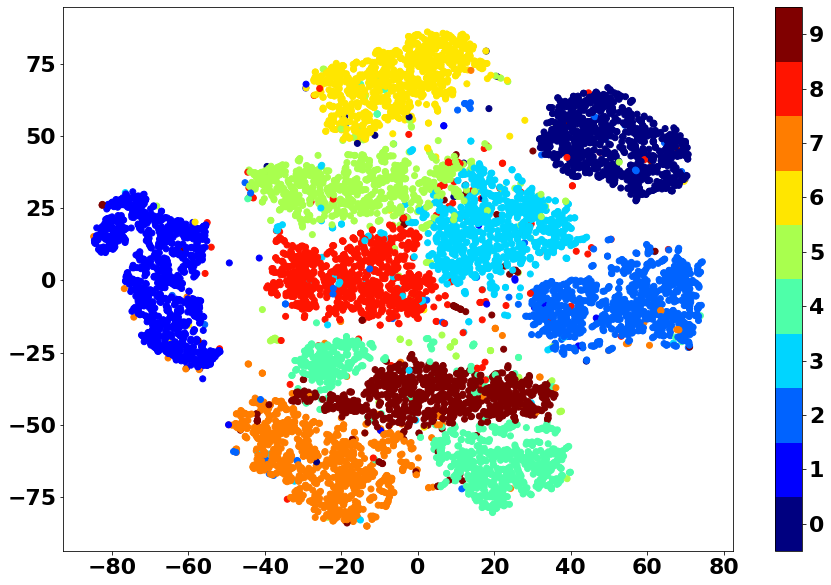

In [ ]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)
figure = plt.figure(figsize=(15, 10))
plt.scatter(x_2d[:, 0], x_2d[:, 1], # 2D image projections
            c=y_test                # per-class colors
            ,cmap=plt.cm.get_cmap("jet", num_classes) 
            # replace "jet" with "plasma" for colors more consistent when printed grayscale
           )
plt.colorbar(ticks=range(num_classes))
plt.clim(-0.5, num_classes - 0.5)
plt.show()

# Denoising With Auto-Encoders

In [ ]:
import os
import math

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

batch_size = 32
num_epochs = 50
random_seed = 42

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
img_height, img_width = x_train.shape[1:]
img_channels = 1
input_shape = (img_height, img_width, img_channels)

del y_train
del y_test

x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape((-1, img_height, img_width, img_channels))
x_test = x_test.reshape((-1, img_height, img_width, img_channels))

print(f'Shape of training set: {x_train.shape}')
print(f'Shape of testing set: {x_test.shape}')

batch_size = 64
train_steps_per_epoch = len(x_train) // batch_size
val_steps_per_epoch = len(x_test) // batch_size

Shape of training set: (60000, 28, 28, 1)
Shape of testing set: (10000, 28, 28, 1)


In [ ]:
code_size = 32

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape

inputs = Input(shape=input_shape, name='input')

inputs_flat = Flatten()(inputs)

enc_1 = Dense(128, activation='relu', name='enc_dense1')(inputs_flat)
enc_2 = Dense(64, activation='relu', name='enc_dense2')(enc_1)
code = Dense(code_size, activation='relu', name='enc_dense3')(enc_2)

# Decoding layers:
dec_1 = Dense(64, activation='relu', name='dec_dense1')(code)
dec_2 = Dense(128, activation='relu', name='dec_dense2')(dec_1)
decoded = Dense(np.prod(input_shape), activation='sigmoid', name='dec_dense3')(dec_2)

decoded_reshape = Reshape(input_shape)(decoded)

# Auto-encoder model:
autoencoder = Model(inputs, decoded_reshape)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
enc_dense1 (Dense)           (None, 128)               100480    
_________________________________________________________________
enc_dense2 (Dense)           (None, 64)                8256      
_________________________________________________________________
enc_dense3 (Dense)           (None, 32)                2080      
_________________________________________________________________
dec_dense1 (Dense)           (None, 64)                2112      
_________________________________________________________________
dec_dense2 (Dense)           (None, 128)               8320  

In [ ]:
def add_noise(img, min_noise_factor=.3, max_noise_factor=.6):
    """
    Add some random noise to the images from an uniform distribution.

    :param img:                 The individual image to corrupt
    :param min_noise_factor:    Min value for the noise random average amplitude
    :param max_noise_factor:    Max value for the noise random average amplitude
    
    return:                     Corrupted Image
    """
    noise_factor = np.random.uniform(min_noise_factor, max_noise_factor)
    noise = np.random.normal(scale=noise_factor, size=img.shape)
    img_noisy = img + noise

    img_noisy = np.clip(img_noisy, 0., 1.)

    return img_noisy

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_image_grid(images, titles=None, figure=None,
                    grayscale=False, transpose=False):
    '''
    Plot a grid of n x m images.

    :param images:       Images in a n x m array
    :param titles:       (opt.) List of m titles for each image column
    :param figure:       (opt.) Pyplot figure (if None, will be created)
    :param grayscale:    (opt.) Flag to draw the images in grayscale
    :param transpose:    (opt.) Flag to transpose the grid

    return             Pyplot figure filled with the images
    '''
    num_cols, num_rows = len(images), len(images[0])
    img_ratio = images[0][0].shape[1] / images[0][0].shape[0]

    if transpose:
        vert_grid_shape, hori_grid_shape = (1, num_rows), (num_cols, 1)
        figsize = (int(num_rows * 5 * img_ratio), num_cols * 5)
        wspace, hspace = 0.2, 0.
    else:
        vert_grid_shape, hori_grid_shape = (num_rows, 1), (1, num_cols)
        figsize = (int(num_cols * 5 * img_ratio), num_rows * 5)
        hspace, wspace = 0.2, 0.

    if figure is None:
        figure = plt.figure(figsize=figsize)
    imshow_params = {'cmap': plt.get_cmap('gray')} if grayscale else {}
    grid_spec = gridspec.GridSpec(*hori_grid_shape, wspace=0, hspace=0)

    for j in range(num_cols):
        grid_spec_j = gridspec.GridSpecFromSubplotSpec(
            *vert_grid_shape, subplot_spec=grid_spec[j], wspace=wspace, hspace=hspace)

        for i in range(num_rows):
            ax_img = figure.add_subplot(grid_spec_j[i])
            # ax_img.axis('off')
            ax_img.set_yticks([])
            ax_img.set_xticks([])
            if titles is not None:
                if transpose:
                    ax_img.set_ylabel(titles[j], fontsize=25)
                else:
                    ax_img.set_title(titles[j], fontsize=15)
            ax_img.imshow(images[j][i], **imshow_params)

    figure.tight_layout()
    return figure

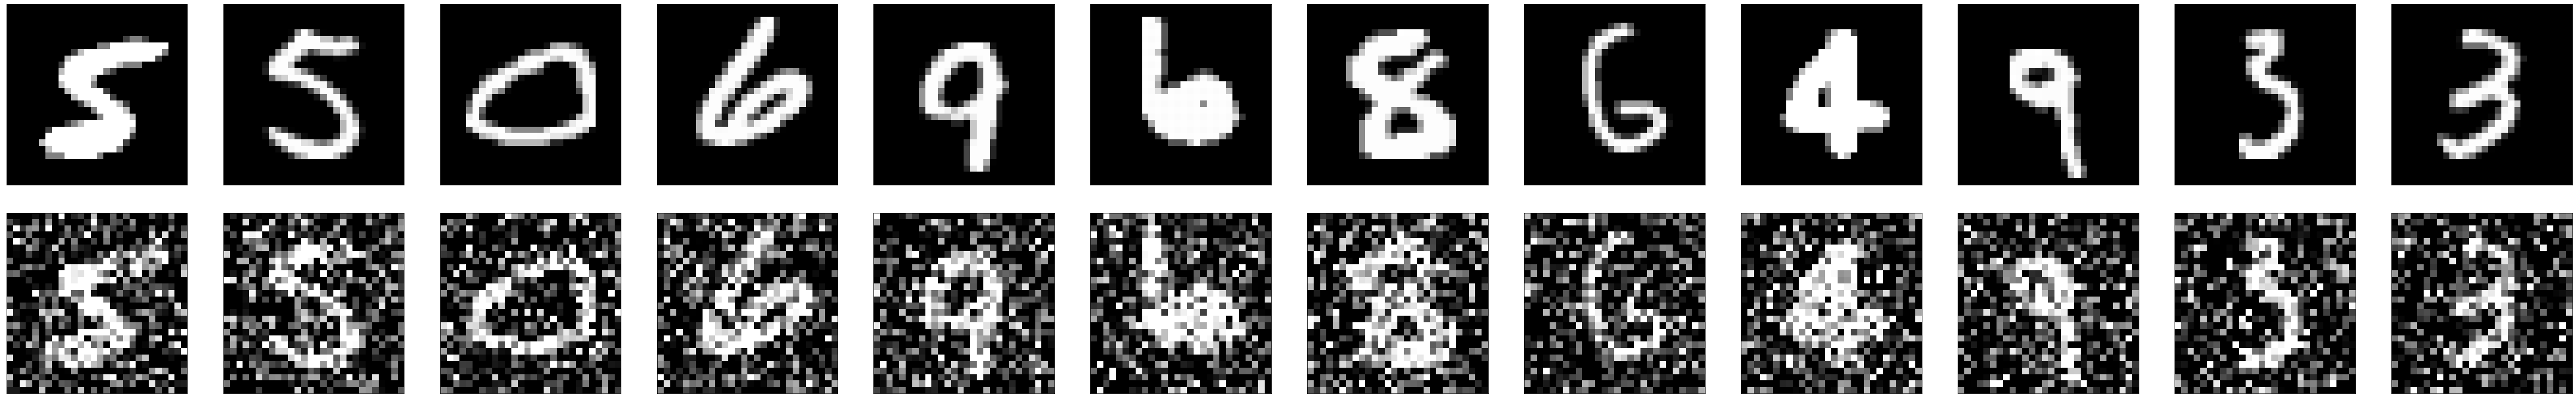

In [ ]:
num_show = 12
random_image_indices = np.random.choice(len(x_test), size=num_show)

orig_samples = x_test[random_image_indices]
noisy_samples = add_noise(orig_samples)

fig = plot_image_grid([np.squeeze(orig_samples), np.squeeze(noisy_samples)],
                    grayscale=True, transpose=True)

fig.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(preprocessing_function=add_noise)

train_generator = train_datagen.flow(x_train, x_train, batch_size=batch_size, 
                                     shuffle=True)
print(type(train_generator))

<class 'keras_preprocessing.image.numpy_array_iterator.NumpyArrayIterator'>


In [ ]:
x_test_noisy = add_noise(x_test)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
val_generator = val_datagen.flow(x_test_noisy, x_test, 
                                 batch_size=batch_size, shuffle=False)

In [ ]:
import functools

psnr_metric = functools.partial(tf.image.psnr, max_val=1.)
psnr_metric.__name__ = "psnr"

In [ ]:
import io

def figure_to_rgb_array(fig):
    """
    Convert figure into a RGB array
    :param fig:         PyPlot Figure
    :return:            RGB array
    """
    figure_buffer = io.BytesIO()
    fig.savefig(figure_buffer, format='png')
    figure_buffer.seek(0)
    figure_string = figure_buffer.getvalue()
    return figure_string


def figure_to_summary(fig, name, step):
    """
    Convert figure into TF summary
    :param fig:             Figure
    :param tag:             Summary name
    :return:                Summary step
    """
    # Transform figure into PNG buffer:
    figure_string = figure_to_rgb_array(fig)

    # Transform PNG buffer into image tensor:
    figure_tensor = tf.image.decode_png(figure_string, channels=4)
    figure_tensor = tf.expand_dims(figure_tensor, 0) # adding batch dimension

    # Using Proto to convert the image string into a summary:
    figure_summary = tf.summary.image(name, figure_tensor, step)

    return figure_summary



class TensorBoardImageGridCallback(tf.keras.callbacks.Callback):
    """ Keras callback for generative models, to draw grids of
        input/predicted/target images into Tensorboard every epoch.
    """

    def __init__(self, log_dir, input_images, target_images=None, tag='images',
                 figsize=(10, 10), dpi=300, grayscale=False, transpose=False,
                 preprocess_fn=None):
        """
        Initialize the Callback.
        :param log_dir:         Folder to write the image summaries into
        :param input_images:    List of input images to use for the grid
        :param target_images:   (opt.) List of target images for the grid
        :param tag:             Tag to name the Tensorboard summary
        :param figsize:         Pyplot figure size for the grid
        :param dpi:             Pyplot figure DPI
        :param grayscale:       Flag to plot the images as grayscale
        :param transpose:       Flag to transpose the image grid
        :param preprocess_fn:   (opt.) Function to pre-process the
                                input/predicted/target image lists before plotting
        """
        super().__init__()

        self.summary_writer = tf.summary.create_file_writer(log_dir)

        self.input_images, self.target_images = input_images, target_images
        self.tag = tag
        self.postprocess_fn = preprocess_fn

        self.image_titles = ['images', 'predicted']
        if self.target_images is not None:
            self.image_titles.append('ground-truth')

        # Initializing the figure:
        self.fig = plt.figure(num=0, figsize=figsize, dpi=dpi)
        self.grayscale = grayscale
        self.transpose = transpose

    def on_epoch_end(self, epoch, logs={}):
        """
        Plot into Tensorboard a grid of image results.
        :param epoch:   Epoch num
        :param logs:    (unused) Dictionary of loss/metrics value for the epoch
        """

        # Get predictions with current model:
        predicted_images = self.model.predict_on_batch(self.input_images)
        if self.postprocess_fn is not None:
            input_images, predicted_images, target_images = self.postprocess_fn(
                self.input_images, predicted_images, self.target_images)
        else:
            input_images, target_images = self.input_images, self.target_images

        # Fill figure with images:
        grid_imgs = [input_images, predicted_images]
        if target_images is not None:
            grid_imgs.append(target_images)
        self.fig.clf()
        self.fig = plot_image_grid(grid_imgs, titles=self.image_titles, figure=self.fig,
                                   grayscale=self.grayscale, transpose=self.transpose)

        with self.summary_writer.as_default():
            # Transform into summary:
            figure_summary = figure_to_summary(self.fig, self.tag, epoch)

            # # Finally, log it:
            # self.summary_writer.add_summary(figure_summary, global_step=epoch)
        self.summary_writer.flush()

    def on_train_end(self, logs={}):
        """
        Close the resources used to plot the grids.
        :param logs:    (unused) Dictionary of loss/metrics value for the epoch
        """
        self.summary_writer.close()
        plt.close(self.fig)

In [ ]:
import collections
# from keras_custom_callbacks import SimpleLogCallback

model_dir  = os.path.join('.', 'models', 'ae_denoising_mnist')

metrics_to_print = collections.OrderedDict([("loss", "loss"), 
                                            ("v-loss", "val_loss"),
                                            ("psnr", "psnr"), 
                                            ("v-psnr", "val_psnr")])
callbacks  = [
    # Callback to interrupt the training if the validation loss/metrics stops improving for some epochs:
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss',
                                     restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1/2):
    # SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=1),
    # Callback to log some validation results as image grids into TensorBoard:
    TensorBoardImageGridCallback(
        log_dir=model_dir, input_images=noisy_samples, target_images=orig_samples, 
        tag='ae_results', figsize=(len(noisy_samples) * 3, 3 * 3), 
        grayscale=True, transpose=True,
        preprocess_fn=lambda img, pred, gt: (
            # Squeezing the images from H x W x 1 to H x W, otherwise Pyplot complains:
            np.squeeze(img, -1), np.squeeze(pred, -1), np.squeeze(gt, -1)))
]

autoencoder.compile(optimizer='adam', loss='binary_crossentropy',
                    metrics=[psnr_metric])

# `model.fit_generator()` works quite similarly to `model.fit()` 
# used with tf.data inputs (c.f. notebooks for Chapter 4).
# In other words, we need to specify the number of batches ("steps") per epoch, 
# for Keras to keep track.
history = autoencoder.fit(
    train_generator, steps_per_epoch=train_steps_per_epoch, epochs=num_epochs,
    validation_data=val_generator, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=callbacks)

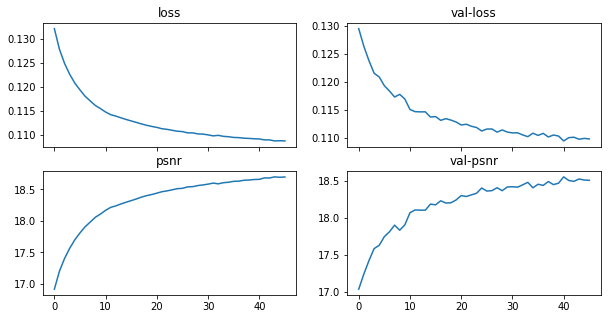

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("psnr")
ax[1, 1].set_title("val-psnr")

ax[0, 0].plot(history.history['loss'])
ax[0, 1].plot(history.history['val_loss'])
ax[1, 0].plot(history.history['psnr'])
ax[1, 1].plot(history.history['val_psnr'])

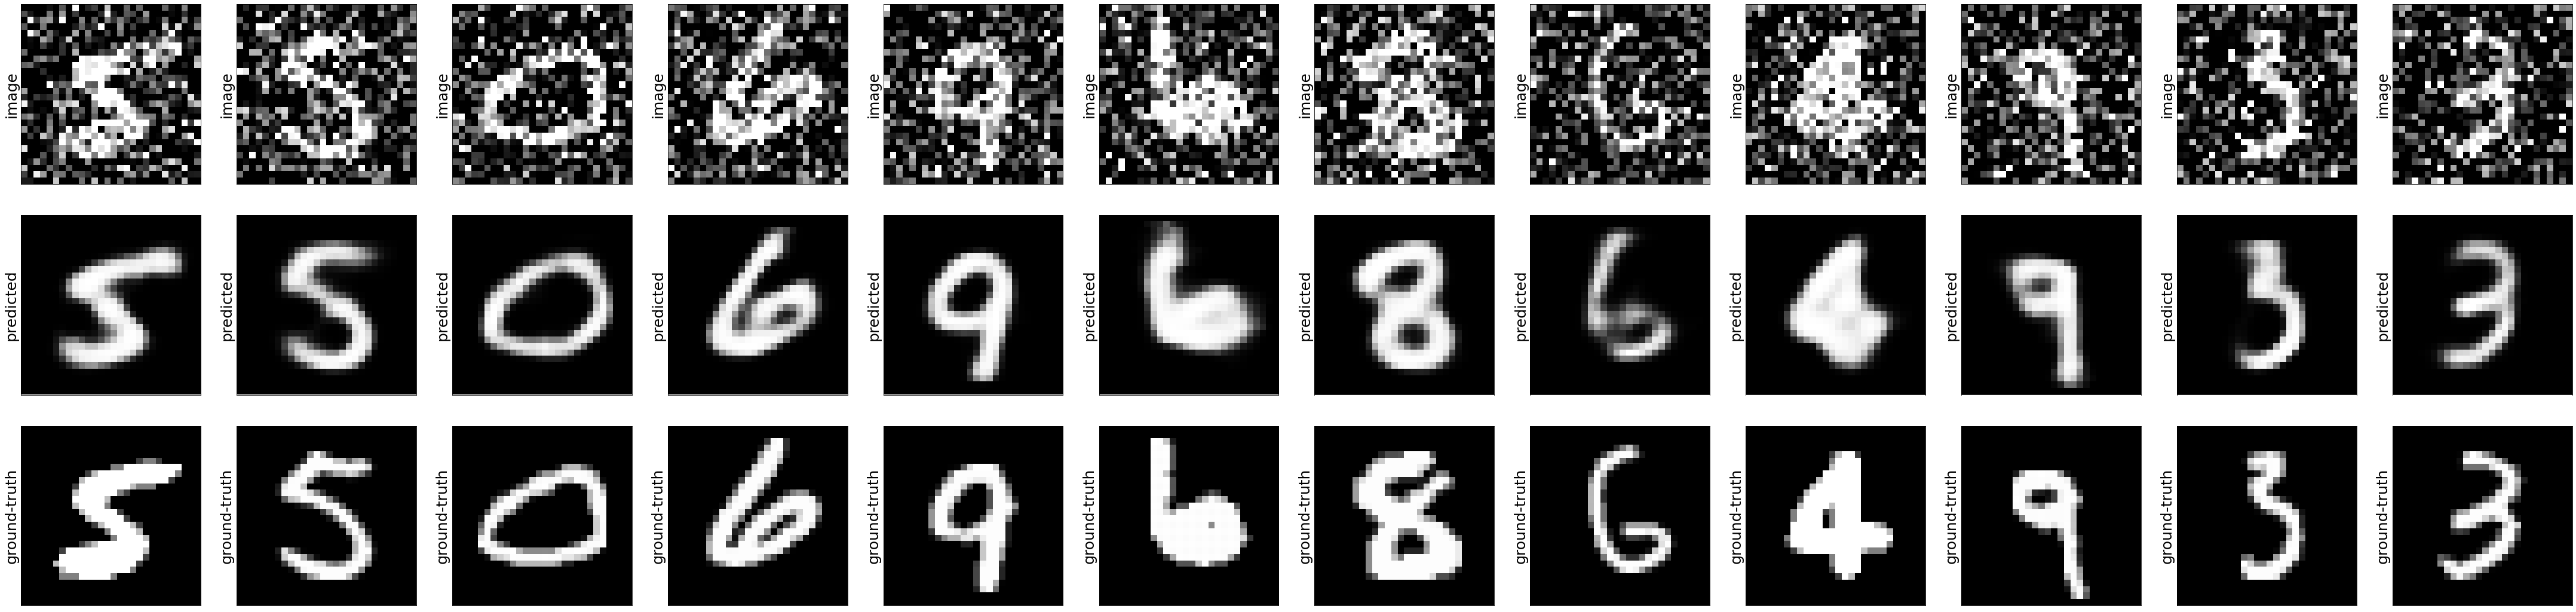

In [ ]:
predicted_samples = autoencoder.predict_on_batch(noisy_samples)

fig = plot_image_grid([np.squeeze(noisy_samples),
                       np.squeeze(predicted_samples),
                       np.squeeze(orig_samples)],
                      titles=['image', 'predicted', 'ground-truth'],
                      grayscale=True, transpose=True)
fig.show()